In [1]:
# system package
import os 
import warnings
from pathlib import Path

# general package
import pandas as pd 
import numpy as np 

# data preprocessing
import pickle # read pickle
from scipy import ndimage # zoom in/out 
from sklearn.model_selection import train_test_split # split dataset
from sklearn import metrics # evaluation

# ploting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Deep Learning/Neural Net
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


warnings.filterwarnings('ignore')

INPUT_DIR='/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono' # input OneDrive path
MODEL_SAVE_DIR='Models' # path to save model 
DEVICE='GPU' # which device to use, CPU/GPU

TRAIN_SIZE=0.8
ERROR_TYPES=['static','buzz','glitch'] # plus undamaged

if not os.path.exists(MODEL_SAVE_DIR):os.mkdir(MODEL_SAVE_DIR) # craete folder to save model

## Data Loading




In [2]:
paths=Path(INPUT_DIR)
paths=list(paths.glob('*.pkl')) # filter files ending with .pkl

print('total files:',len(paths))
print(paths[:5])

total files: 675
[PosixPath('/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono/WAXQ_39_buzz_SNR6.pkl'), PosixPath('/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono/WAXQ_29_glitch_SNRinf.pkl'), PosixPath('/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono/WHTZ_48_buzz_SNR-6.pkl'), PosixPath('/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono/WAXQ_12_buzz_SNR12.pkl'), PosixPath('/Users/alexwang/Library/CloudStorage/OneDrive-iHeartMediaInc/test_files_mono/KYLD_44_glitch_SNRinf.pkl')]


In [3]:
df_all=pd.DataFrame({'filename':paths})
df_all['filename']=df_all['filename'].astype(str)
df_all['label_raw']=None # place holder

for ERROR_TYPE in ERROR_TYPES:
    df_all['label_raw']=np.where(df_all['filename'].str.contains(ERROR_TYPE),ERROR_TYPE,df_all['label_raw']) # extract label from filename

df_all['label_raw']=np.where(df_all['filename'].str.contains('inf'),'undamaged',df_all['label_raw']) # extract undamaged label
df_all['label']=df_all['label_raw'].astype('category').cat.codes # label encoding
df_all

,filename,label_raw,label
0,/Users/alexwang/Library/CloudStorage/OneDrive-...,buzz,0
1,/Users/alexwang/Library/CloudStorage/OneDrive-...,undamaged,3
2,/Users/alexwang/Library/CloudStorage/OneDrive-...,buzz,0
3,/Users/alexwang/Library/CloudStorage/OneDrive-...,buzz,0
4,/Users/alexwang/Library/CloudStorage/OneDrive-...,undamaged,3
...,...,...,...
670,/Users/alexwang/Library/CloudStorage/OneDrive-...,static,2
671,/Users/alexwang/Library/CloudStorage/OneDrive-...,static,2
672,/Users/alexwang/Library/CloudStorage/OneDrive-...,glitch,1
673,/Users/alexwang/Library/CloudStorage/OneDrive-...,static,2


# Parsing & EDA

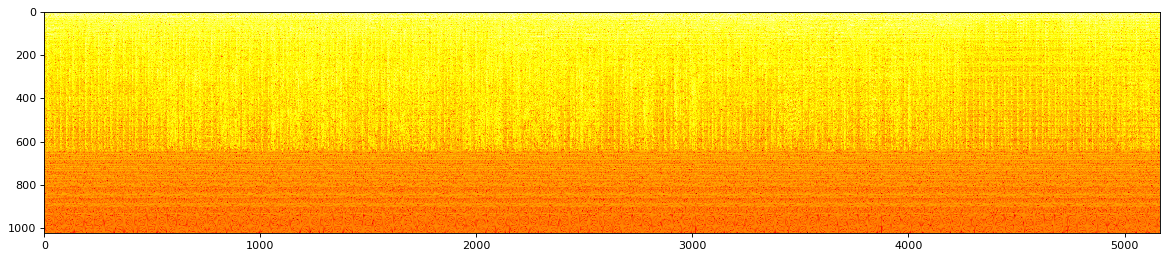

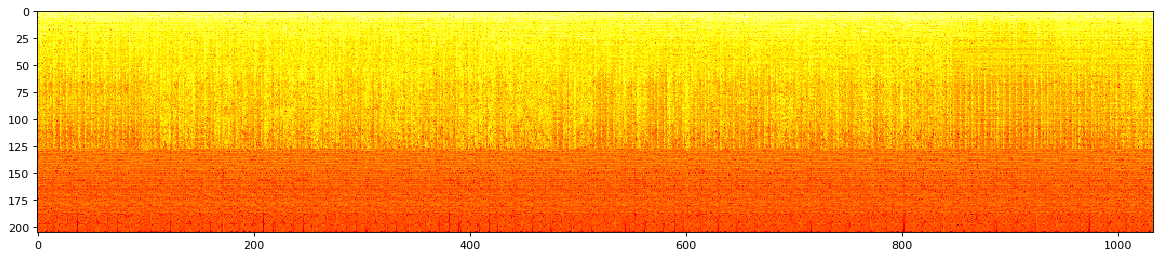

In [4]:
file=df_all.filename.iloc[0] # sample file
a=pickle.load(open(file,'rb'))[-1] # keep only spectrum

figure(figsize=(18, 16), dpi=80)
plt.imshow(a, cmap='hot', interpolation='nearest') # raw resolution 

figure(figsize=(18, 16), dpi=80)
plt.imshow(ndimage.zoom(a, 0.2), cmap='hot', interpolation='nearest') # shrinked data
plt.show()



In [5]:
def prepare_data(file): # pipeline, read, resize and min/max scaling (required for neural net)
    a=pickle.load(open(file,'rb'))[-1]
    a=ndimage.zoom(a, 0.2)
    a-=a.min()
    a/=a.max()
    return a

# Prepare Data

In [6]:
for n,row in df_all.iterrows():
    if not n % 50: print(n)  # print progress

    filename=row.filename

    x=prepare_data(filename)
    y=row.label

    if not n: 
        x_all=x.reshape(1,x.shape[0],x.shape[1])
        y_all=y

    else:
        x_all=np.vstack((x_all,x.reshape(1,x.shape[0],x.shape[1])))
        y_all=np.vstack((y_all,y))
    

print('full data shape',x_all.shape,y_all.shape)
x_train, x_test, y_train, y_test, file_name_train, file_name_test = train_test_split(x_all, y_all, df_all.filename.tolist(), train_size=TRAIN_SIZE, random_state=42)

print('train/test data shape',x_train.shape,y_train.shape,x_test.shape,y_test.shape)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
full data shape (675, 205, 1033) (675, 1)
train/test data shape (540, 205, 1033) (540, 1) (135, 205, 1033) (135, 1)


# Modeling

In [7]:
device=tf.config.list_logical_devices(device_type=DEVICE)[0].name # set & check device
print(device)

/device:GPU:0
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-05 15:20:52.364667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-05 15:20:52.364813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
with tf.device(device): # build NN
    inputs = layers.Input(shape=(x_train.shape[1], x_train.shape[2], 1))
    x1 = tf.keras.layers.Flatten()(inputs)

    x1 = tf.keras.layers.Dense(256, activation="LeakyReLU")(x1)
    x1 = tf.keras.layers.Dense(1024, activation="LeakyReLU")(x1)
    x1 = tf.keras.layers.Dense(32, activation="LeakyReLU")(x1)
    
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x1)

    model=Model(inputs=inputs, outputs=outputs)

# Training

In [9]:
with tf.device(device): # Compile NN
    monitor = EarlyStopping(monitor='val_loss', min_delta=1, patience=25, verbose=1, mode='auto', restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, min_lr=1e-10, verbose = 1)
    checkpoiter = tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_DIR, monitor='val_loss', save_freq='epoch', verbose = 1, save_best_only = True)


    opt = tf.keras.optimizers.Adam(learning_rate=1e-03)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=opt, metrics=['SparseCategoricalAccuracy'])

In [10]:
with tf.device(device): # train NN
    history = model.fit(x=x_train,y=y_train, epochs=20, validation_data = (x_test,y_test), callbacks=[monitor, reduce_lr, checkpoiter],
                        verbose = 1,batch_size=32)

Epoch 1/20


2022-07-05 15:20:53.286853: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-05 15:20:53.453838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17/17 [==============================] - ETA: 0s - loss: 169.2369 - sparse_categorical_accuracy: 0.2426

2022-07-05 15:20:55.542033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 42.18560, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 5s 279ms/step - loss: 169.2369 - sparse_categorical_accuracy: 0.2426 - val_loss: 42.1856 - val_sparse_categorical_accuracy: 0.2963 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - ETA: 0s - loss: 52.1242 - sparse_categorical_accuracy: 0.3204
Epoch 2: val_loss improved from 42.18560 to 18.91098, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 252ms/step - loss: 52.1242 - sparse_categorical_accuracy: 0.3204 - val_loss: 18.9110 - val_sparse_categorical_accuracy: 0.5185 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - ETA: 0s - loss: 5.8657 - sparse_categorical_accuracy: 0.6444
Epoch 3: val_loss improved from 18.91098 to 2.31004, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 250ms/step - loss: 5.8657 - sparse_categorical_accuracy: 0.6444 - val_loss: 2.3100 - val_sparse_categorical_accuracy: 0.6741 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - ETA: 0s - loss: 1.4704 - sparse_categorical_accuracy: 0.7481
Epoch 4: val_loss improved from 2.31004 to 1.40716, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 247ms/step - loss: 1.4704 - sparse_categorical_accuracy: 0.7481 - val_loss: 1.4072 - val_sparse_categorical_accuracy: 0.7185 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - ETA: 0s - loss: 1.0071 - sparse_categorical_accuracy: 0.8296
Epoch 5: val_loss did not improve from 1.40716
17/17 [==============================] - 2s 123ms/step - loss: 1.0071 - sparse_categorical_accuracy: 0.8296 - val_loss: 2.6889 - val_sparse_categorical_accuracy: 0.6889 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - ETA: 0s - loss: 0.7224 - sparse_categorical_accuracy: 0.9167
Epoch 6: val_loss improved from 1.40716 to 0.33009, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 252ms/step - loss: 0.7224 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.3301 - val_sparse_categorical_accuracy: 0.9630 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - ETA: 0s - loss: 0.0141 - sparse_categorical_accuracy: 0.9926
Epoch 7: val_loss improved from 0.33009 to 0.06283, saving model to Models


INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 248ms/step - loss: 0.0141 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0628 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 8/20
17/17 [==============================] - ETA: 0s - loss: 0.0052 - sparse_categorical_accuracy: 0.9981
Epoch 8: val_loss did not improve from 0.06283
17/17 [==============================] - 2s 124ms/step - loss: 0.0052 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.2469 - val_sparse_categorical_accuracy: 0.9704 - lr: 0.0010
Epoch 9/20
17/17 [==============================] - ETA: 0s - loss: 0.0226 - sparse_categorical_accuracy: 0.9944
Epoch 9: val_loss did not improve from 0.06283
17/17 [==============================] - 2s 124ms/step - loss: 0.0226 - sparse_categorical_accuracy: 0.9944 - val_loss: 0.0952 - val_sparse_categorical_accuracy: 0.9704 - lr: 0.0010
Epoch 10/20
17/17 [==============================] - ETA: 0s - loss: 0.0249 - sparse_categorical_accuracy: 0.9963
Epoch 10: val_loss i

INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 243ms/step - loss: 0.0249 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0426 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 11/20
17/17 [==============================] - ETA: 0s - loss: 0.0155 - sparse_categorical_accuracy: 0.9926
Epoch 11: val_loss did not improve from 0.04261
17/17 [==============================] - 2s 124ms/step - loss: 0.0155 - sparse_categorical_accuracy: 0.9926 - val_loss: 0.0444 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 12/20
17/17 [==============================] - ETA: 0s - loss: 0.0023 - sparse_categorical_accuracy: 0.9981
Epoch 12: val_loss did not improve from 0.04261
17/17 [==============================] - 2s 125ms/step - loss: 0.0023 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.1277 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 13/20
17/17 [==============================] - ETA: 0s - loss: 0.0080 - sparse_categorical_accuracy: 0.9963
Epoch 13: val_lo

INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 250ms/step - loss: 0.0080 - sparse_categorical_accuracy: 0.9963 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 14/20
17/17 [==============================] - ETA: 0s - loss: 0.0766 - sparse_categorical_accuracy: 0.9852
Epoch 14: val_loss did not improve from 0.04124
17/17 [==============================] - 2s 123ms/step - loss: 0.0766 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.1898 - val_sparse_categorical_accuracy: 0.9778 - lr: 0.0010
Epoch 15/20
17/17 [==============================] - ETA: 0s - loss: 0.0522 - sparse_categorical_accuracy: 0.9889
Epoch 15: val_loss did not improve from 0.04124
17/17 [==============================] - 2s 124ms/step - loss: 0.0522 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.4094 - val_sparse_categorical_accuracy: 0.9778 - lr: 0.0010
Epoch 16/20
17/17 [==============================] - ETA: 0s - loss: 0.0476 - sparse_categorical_accuracy: 0.9944
Epoch 16: val_lo

INFO:tensorflow:Assets written to: Models/assets


INFO:tensorflow:Assets written to: Models/assets


17/17 [==============================] - 4s 248ms/step - loss: 0.0045 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0378 - val_sparse_categorical_accuracy: 0.9852 - lr: 0.0010
Epoch 20/20
17/17 [==============================] - ETA: 0s - loss: 0.0558 - sparse_categorical_accuracy: 0.9796
Epoch 20: val_loss did not improve from 0.03777
17/17 [==============================] - 2s 123ms/step - loss: 0.0558 - sparse_categorical_accuracy: 0.9796 - val_loss: 0.2347 - val_sparse_categorical_accuracy: 0.9778 - lr: 0.0010


# Evaluation

In [11]:
y_pred_train=model.predict(x_train) # make prediction
y_pred_test=model.predict(x_test)

 2/17 [==>...........................] - ETA: 1s

2022-07-05 15:21:54.673832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 86ms/step


In [12]:
categories_name=df_all[['label_raw','label']].drop_duplicates().sort_values('label').label_raw.tolist()[::-1] # extract original class name instead of encoded label

print('='*20,'Training Data','='*20)
print(pd.DataFrame(metrics.confusion_matrix(y_pred_train.argmax(axis=1), y_train),columns=categories_name,index=categories_name))
print('-'*60)
print(metrics.classification_report(y_pred_train.argmax(axis=1), 
                                    y_train,
                                    digits=4,
                                    target_names=categories_name))

print('')
print('='*20,'Testing Data','='*20)
print(pd.DataFrame(metrics.confusion_matrix(y_pred_test.argmax(axis=1), y_test),columns=categories_name,index=categories_name))
print('-'*60)
print(metrics.classification_report(y_pred_test.argmax(axis=1), 
                                    y_test,
                                    digits=4,
                                    target_names=categories_name))

==================== Training Data ====================
           undamaged  static  glitch  buzz
undamaged        143       0       0     1
static             0     140       0     0
glitch             0       0     145     0
buzz               0       0       0   111
------------------------------------------------------------
              precision    recall  f1-score   support

   undamaged     1.0000    0.9931    0.9965       144
      static     1.0000    1.0000    1.0000       140
      glitch     1.0000    1.0000    1.0000       145
        buzz     0.9911    1.0000    0.9955       111

    accuracy                         0.9981       540
   macro avg     0.9978    0.9983    0.9980       540
weighted avg     0.9982    0.9981    0.9981       540


==================== Testing Data ====================
           undamaged  static  glitch  buzz
undamaged         37       0       0     3
static             0      40       0     0
glitch             0       0      35     0
buzz 

# Find wrong classified file name

In [13]:
# build label/filename map
y_pred_all=np.concatenate((y_pred_train.argmax(axis=1),y_pred_test.argmax(axis=1)))
y_true_all=np.concatenate((y_train,y_test)).reshape(-1)
file_name_all=np.concatenate((file_name_train,file_name_test))

df_eval=pd.DataFrame({'filename':file_name_all,
                      'y_true':y_true_all,
                      'y_pred':y_pred_all})
df_eval['short_name']=df_eval.filename.apply(lambda x:x.split('/')[-1])
df_eval

,filename,y_true,y_pred,short_name
0,/Users/alexwang/Library/CloudStorage/OneDrive-...,0,0,KDMX_54_buzz_SNR6.pkl
1,/Users/alexwang/Library/CloudStorage/OneDrive-...,1,1,KIIS_32_glitch_SNR-6.pkl
2,/Users/alexwang/Library/CloudStorage/OneDrive-...,1,1,WASH_53_glitch_SNR6.pkl
3,/Users/alexwang/Library/CloudStorage/OneDrive-...,3,3,KIIS_75_buzz_SNRinf.pkl
4,/Users/alexwang/Library/CloudStorage/OneDrive-...,2,2,WHTZ_16_static_SNR-6.pkl
...,...,...,...,...
670,/Users/alexwang/Library/CloudStorage/OneDrive-...,1,1,WRDA_62_glitch_SNR-6.pkl
671,/Users/alexwang/Library/CloudStorage/OneDrive-...,0,0,KDGE_39_buzz_SNR6.pkl
672,/Users/alexwang/Library/CloudStorage/OneDrive-...,1,1,WASH_68_glitch_SNR6.pkl
673,/Users/alexwang/Library/CloudStorage/OneDrive-...,1,1,WRDA_35_glitch_SNR0.pkl


In [14]:
# filter wrong classified file
df_eval[df_eval.y_true!=df_eval.y_pred] # SNR is inf, this is a good signal

,filename,y_true,y_pred,short_name
194,/Users/alexwang/Library/CloudStorage/OneDrive-...,3,0,WASH_58_static_SNRinf.pkl
540,/Users/alexwang/Library/CloudStorage/OneDrive-...,3,0,KYLD_43_static_SNRinf.pkl
650,/Users/alexwang/Library/CloudStorage/OneDrive-...,3,0,KDGE_29_glitch_SNRinf.pkl
660,/Users/alexwang/Library/CloudStorage/OneDrive-...,3,0,KYLD_74_glitch_SNRinf.pkl


In [15]:
# show label codes & name mapping
df_all[['label_raw','label']].drop_duplicates().sort_values('label')

,label_raw,label
0,buzz,0
7,glitch,1
10,static,2
1,undamaged,3
